This file does some exploratory data analysis on the garbage dataset

In [ ]:
# import pandas
import pandas as pd

# read in training dataset and print to see if structure is correct:
train_df = pd.read_csv("../Data/one-indexed-files-notrash_train.txt", sep=" ", header=None, names=["filename", "label"])
print(train_df.head())

           filename  label
0  cardboard202.jpg      3
1      paper472.jpg      2
2      paper522.jpg      2
3      glass189.jpg      1
4      glass325.jpg      1


In [4]:
# read in validation and training set:
val_df = pd.read_csv("../Data/one-indexed-files-notrash_val.txt", sep=" ", header=None, names=["filename", "label"])
test_df = pd.read_csv("../Data/one-indexed-files-notrash_test.txt", sep=" ", header=None, names=["filename", "label"])

## Exploratory Data Analysis:

In [5]:
# Look at dataset sizes
print(len(train_df), len(val_df), len(test_df))

# Check label distribution
print(train_df['label'].value_counts())
print(val_df['label'].value_counts())
print(test_df['label'].value_counts())

1768 328 431
label
2    403
1    354
4    347
3    287
5    286
6     91
Name: count, dtype: int64
label
2    83
1    65
4    61
5    56
3    46
6    17
Name: count, dtype: int64
label
2    108
1     82
4     74
3     70
5     68
6     29
Name: count, dtype: int64


Now we experiment with a simple CNN in PyTorch

In [7]:
# import libraries
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [9]:
# define garbage dataset class:
class GarbageDataset(Dataset):
    # constructor
    def __init__(self, df, img_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.transform = transform
    
    # get length of dataset
    def __len__(self):
        return len(self.df)
    
    # get item from images
    def __getitem__(self, idx):
        img_name = self.df.loc[idx, 'filename']
        label = self.df.loc[idx, 'label'] - 1  # assuming labels start at 1
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label



In [17]:
# transform images to a consistent size and pattern for easier processing
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # keep it small for now
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [19]:
img_directory = "../Data/Images/"
dataset = GarbageDataset(train_df, img_directory, transform=transform)

# Test length
print(f"Dataset length: {len(dataset)}")   

# Test __getitem__ by fetching first item
image, label = dataset[0]
print(f"Label: {label}")
print(f"Image shape: {image.shape}")


Dataset length: 1768
Label: 2
Image shape: torch.Size([3, 128, 128])


In [21]:
# begin data loading:
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):  # adjust to your number of classes
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)          # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [25]:
# prep model for training
model = SimpleCNN(num_classes=6)  # set 6 classes for 6 different types of garbage
criterion = nn.CrossEntropyLoss()   # set loss function to be cross entropy loss (ideal for classification algorithms)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)   

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epoch_losses = []

for epoch in range(10):  # num_epochs
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
    epoch_losses.append(running_loss)
    print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Epoch 1, Loss: 87.6353
Epoch 2, Loss: 64.7862
Epoch 3, Loss: 49.6210
Epoch 4, Loss: 39.0917
Epoch 5, Loss: 29.6540
Epoch 6, Loss: 18.7557
Epoch 7, Loss: 12.8286
Epoch 8, Loss: 8.2675
Epoch 9, Loss: 5.4356
Epoch 10, Loss: 3.5676


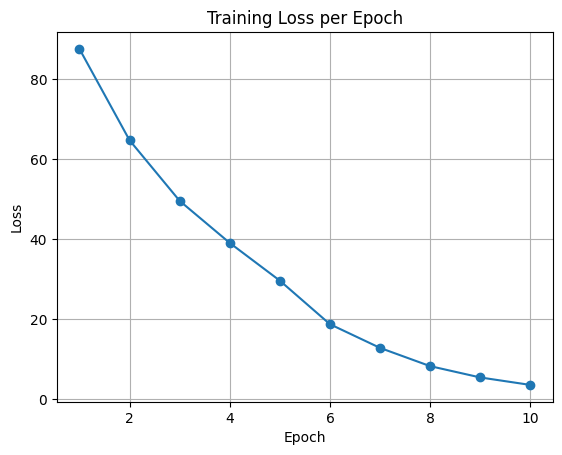

In [28]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [29]:
# prepare validation and test sets:
val_dataset = GarbageDataset(val_df, img_directory, transform=transform)
test_dataset = GarbageDataset(test_df, img_directory, transform=transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
# function to evaluate model on a new set of data (either validation or test set)
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [33]:
# evaluate model on validation set:
val_acc = evaluate(model, val_loader, device)
print(f"Validation Accuracy: {val_acc:.4f}")

Validation Accuracy: 0.6738


In [35]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

def get_preds_and_labels(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

preds, labels = get_preds_and_labels(model, val_loader, device)

print("Classification Report:")
print(classification_report(labels, preds))

print("Confusion Matrix:")
print(confusion_matrix(labels, preds))

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67        65
           1       0.86      0.78      0.82        83
           2       0.70      0.85      0.76        46
           3       0.57      0.52      0.55        61
           4       0.53      0.59      0.56        56
           5       0.56      0.59      0.57        17

    accuracy                           0.67       328
   macro avg       0.65      0.66      0.66       328
weighted avg       0.68      0.67      0.67       328

Confusion Matrix:
[[42  3  1  9  9  1]
 [ 2 65  5  4  6  1]
 [ 1  1 39  4  1  0]
 [ 7  5  4 32 10  3]
 [ 6  2  7  5 33  3]
 [ 2  0  0  2  3 10]]
